In [1]:
#Notebook's settings
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


import sys
Folder='/Users/egordanilov/Desktop/Lesta_shared/GRF_strong_lensing/jax-strong-lensing/'
sys.path.append(Folder)

from tqdm import tqdm
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import matplotlib as mpl

from GRF_perturbations.Modules.GRF_generation import *


#Fontsize
FS=18

/usr/local/Caskroom/miniforge/base/envs/env_jax/lib/python3.8/site-packages/jax/_src/lib/__init__.py:31: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


# Fourier frequencies

In [2]:
npix=100
pix_scl=0.08

k_grid,nonsingular_k_grid=get_k_grid(npix,pix_scl)

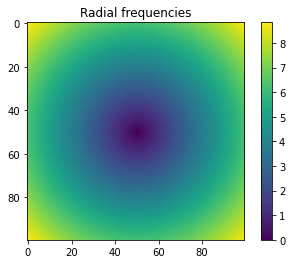

In [3]:
plt.imshow(np.fft.fftshift(k_grid))
plt.colorbar()
plt.title('Radial frequencies')
plt.show()

# Fourier phase

In [4]:
#Uniformly sampled complex phases
def get_Fourier_phase_unif(npix,seed):
    """
    Parameters
    ----------
    npix: int
        Number of pixels along side of the image
    seed: int
        seed for random cos,sin generation

    Returns
    -------
    Fourier phase grid: (npix,npix) complex
        grid of Fourier phases obtained using Box-Muller transform Polar form (lookup wiki)
    """
    np.random.seed(seed)
    #rng=np.random.default_rng(seed)

    Fourier_phases = np.zeros ([npix, npix], dtype='cfloat') # Empty matrix to be filled in for the Fourier plane
    j= 0 + 1j # Defining the complex number

    for y in range(npix):
        for x in range(npix):

            # Filling in the grid
            if x==0 and y==0: # Subtract mean instead of modyfing Fourier image
                Fourier_phases[y,x] = 1.0
                continue

            phi=np.random.uniform(0,2*np.pi)
            z1=np.cos(phi)
            z2=np.sin(phi)
            #z1,z2=Box_Muller_transform()

            # three points that need to be real valued to get a real image after FFT:
            if x== 0 and y==npix/2:
                Fourier_phases[y,x] = z1
            elif x==npix/2 and y==0:
                Fourier_phases[y,x] = z1
            elif x==npix/2 and y==npix/2:
                Fourier_phases[y,x] = z1
            else :
                Fourier_phases[y,x] = z1+j*z2

            Fourier_phases[-y,-x] = Fourier_phases[y,x].conjugate()

        if y>npix/2.:
            break

    return Fourier_phases

In [5]:
GRFs=np.zeros((1000,100,100))

for i in tqdm(range(1000)):
    Fourier_phase=get_Fourier_phase(npix,i)
    GRFs[i]=get_jaxified_GRF([-7,2],nonsingular_k_grid,Fourier_phase)

100%|████████████████████████████████| 1000/1000 [00:33<00:00, 29.77it/s]


mean=0  0.36508777514732094
from normal 0.02167397191273


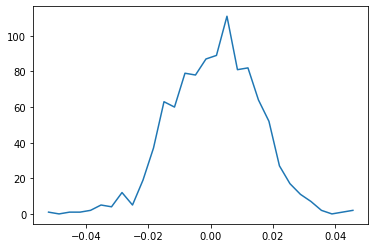

In [6]:
i=0
j=40
data,x=np.histogram(GRFs[:,i,j],bins=30)
plt.plot(x[1:],data)
print('mean=0 ', sc.stats.ttest_1samp(GRFs[:,i,j],0,alternative='two-sided')[1])
print('from normal', sc.stats.normaltest(GRFs[:,i,j])[1])

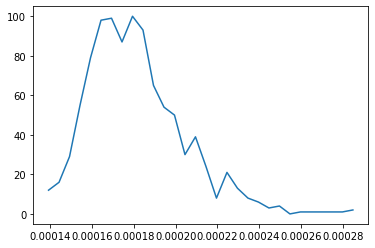

In [8]:
data,x=np.histogram(GRFs.var(axis=(1,2)),bins=30)
plt.plot(x[1:],data)

In [9]:
zero_mean_mask=np.ones_like(nonsingular_k_grid)
zero_mean_mask[0,0]=0
PS=nonsingular_Power_spectrum([-7,2],nonsingular_k_grid)*zero_mean_mask

In [11]:
PS.sum()

DeviceArray(0.00017828, dtype=float64)

In [17]:
GRFs.var(axis=(1,2)).min()

0.00013416517322771153

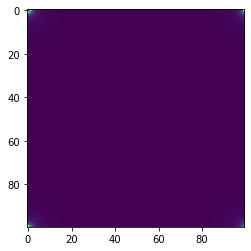

In [34]:
plt.imshow(PS)

In [20]:
GRFs_unif=np.zeros((1000,100,100))

for i in tqdm(range(1000)):
    Fourier_phase=get_Fourier_phase_unif(npix,i)
    GRFs_unif[i]=get_jaxified_GRF([-7,2],nonsingular_k_grid,Fourier_phase)

100%|████████████████████████████████| 1000/1000 [00:20<00:00, 48.86it/s]


mean=0  0.4743668996303608
from normal 0.41980486720682253


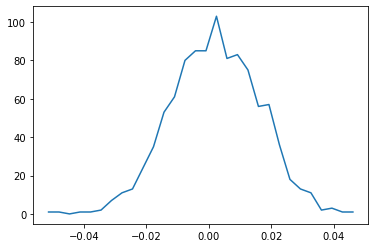

In [23]:
i=0
j=40
data,x=np.histogram(GRFs_unif[:,i,j],bins=30)
plt.plot(x[1:],data)
print('mean=0 ', sc.stats.ttest_1samp(GRFs_unif[:,i,j],0,alternative='two-sided')[1])
print('from normal', sc.stats.normaltest(GRFs_unif[:,i,j])[1])

In [5]:
np.where(np.abs((np.abs(Fourier_phase)-1.))>1e-15)

(array([ 0,  0,  0, ..., 99, 99, 99]), array([ 1,  2,  3, ..., 97, 98, 99]))

These are the points set to be real valued in order to obtain real valued GRF

# Scale of perturbations

In [18]:
GRFs=np.zeros((6,100,100))
zero_mean_matrix=np.ones_like(k_grid)
zero_mean_matrix[0,0]=0

for i in range(6):
    unnormalised_spectrum=nonsingular_Power_spectrum([0,i],nonsingular_k_grid)*zero_mean_matrix
        
    A=1/unnormalised_spectrum.sum()
    GRFs[i]=get_jaxified_GRF([np.log10(A),i],nonsingular_k_grid,Fourier_phase)

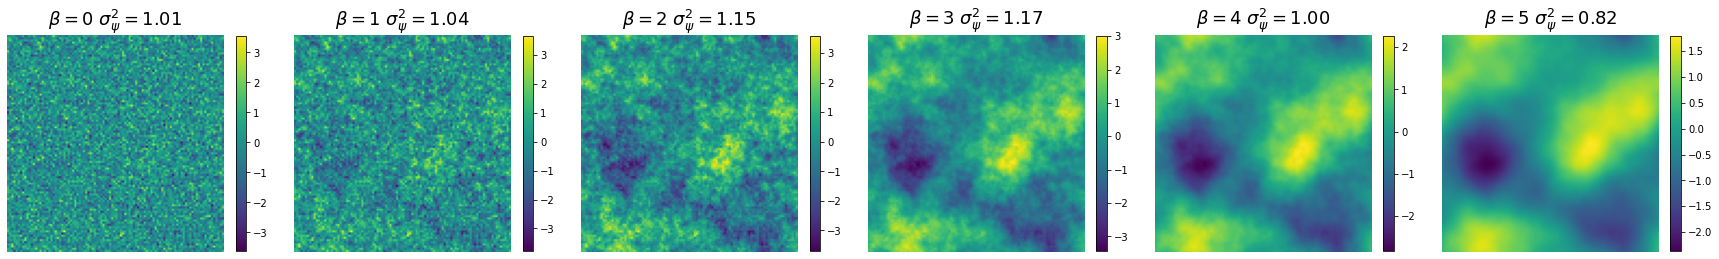

In [19]:
fig,ax=plt.subplots(1,6,figsize=(30,7))

img_arr=[]

for i in range(6):
    img_arr+=[ax[i].imshow(GRFs[i])]
    ax[i].axis('off')
    ax[i].set_title(r'$\beta=$'+'{:.0f} '.format(i)+r'$\sigma^2_{\psi}=$'+'{:.2f}'.format(GRFs[i].var()),fontsize=FS)
    plt.colorbar(img_arr[i],ax=ax[i],fraction=0.045)
    
    

# Parseval's theorem

In [20]:
spectral_energy=np.zeros((100,100))
variance=np.zeros((100,100))
betas=np.linspace(0,4,100)
zero_mean_matrix=np.ones_like(k_grid)
zero_mean_matrix[0,0]=0

expected_variance=1

for seed in tqdm(range(100)):
    Fourier_phase=get_Fourier_phase(npix,seed)
    for i,beta in enumerate(betas):
        unnormalised_spectrum=nonsingular_Power_spectrum([0,beta],nonsingular_k_grid)*zero_mean_matrix
        
        A=1/unnormalised_spectrum.sum()
        
        spectrum=nonsingular_Power_spectrum([np.log10(A),beta],nonsingular_k_grid)*zero_mean_matrix
        spectral_energy[i,seed]=spectrum.sum()
        
        GRF=get_jaxified_GRF([np.log10(A),beta],nonsingular_k_grid,Fourier_phase)
        variance[i,seed]=GRF.var()
        
        

100%|███████████████████████████████████████████| 100/100 [00:12<00:00,  8.08it/s]


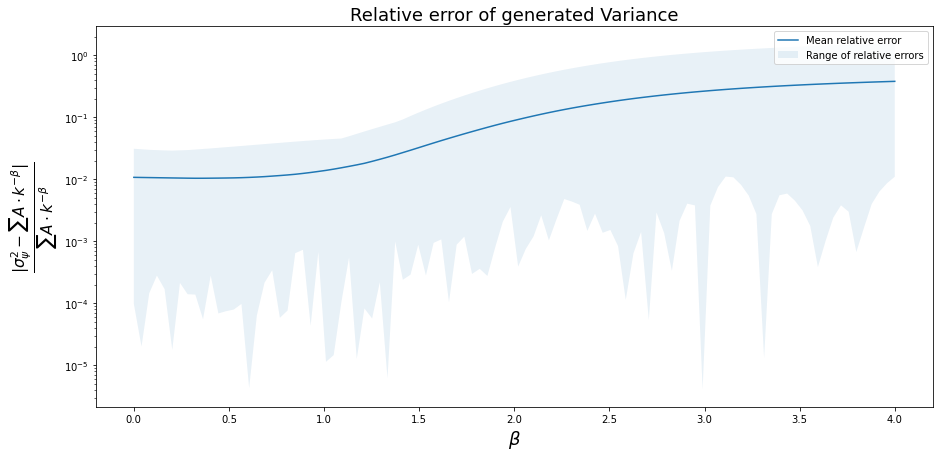

In [21]:
relative_error=np.abs((variance-spectral_energy)/spectral_energy)

plt.figure(figsize=(15,7))
plt.plot(betas,relative_error.mean(axis=-1),label='Mean relative error')
plt.fill_between(betas,relative_error.min(axis=-1),relative_error.max(axis=-1),alpha=0.1,label='Range of relative errors')

plt.yscale('log')
plt.xlabel(r'$\beta$',fontsize=FS)
plt.ylabel(r'$\frac{|\sigma^2_{\psi}-\sum A\cdot k^{-\beta}|}{\sum A\cdot k^{-\beta}}$',fontsize=22)

plt.legend()
plt.title('Relative error of generated Variance',fontsize=FS)
plt.show()

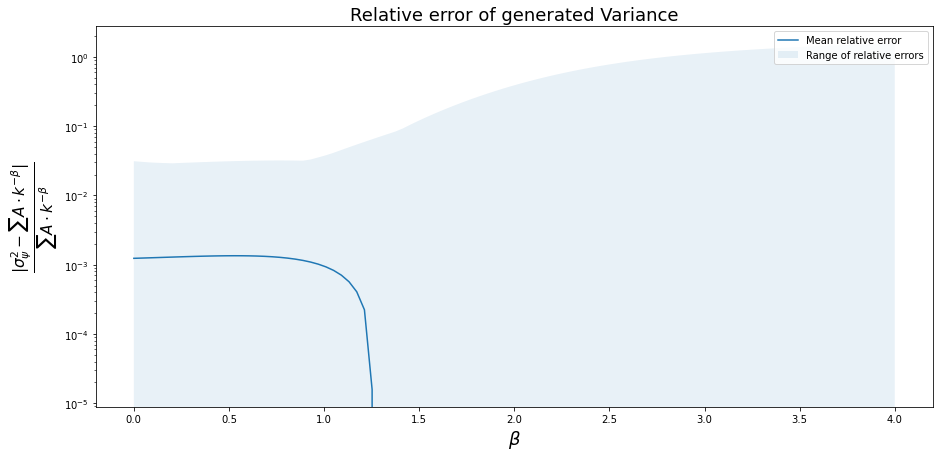

In [25]:
relative_error=(variance-spectral_energy)/spectral_energy

plt.figure(figsize=(15,7))
plt.plot(betas,relative_error.mean(axis=-1),label='Mean relative error')
plt.fill_between(betas,relative_error.min(axis=-1),relative_error.max(axis=-1),alpha=0.1,label='Range of relative errors')

plt.yscale('log')
plt.xlabel(r'$\beta$',fontsize=FS)
plt.ylabel(r'$\frac{|\sigma^2_{\psi}-\sum A\cdot k^{-\beta}|}{\sum A\cdot k^{-\beta}}$',fontsize=22)

plt.legend()
plt.title('Relative error of generated Variance',fontsize=FS)
plt.show()

# Normality test

In [22]:
GRF_value=np.zeros(1000)

expected_variance=1
unnormalised_spectrum=nonsingular_Power_spectrum([0,3],nonsingular_k_grid)*zero_mean_matrix
        
A=1/unnormalised_spectrum.sum()

for i in tqdm(range(1000)):

    
    Fourier_phase=get_Fourier_phase(npix,i)
    GRF=get_jaxified_GRF([np.log10(A),3],nonsingular_k_grid,Fourier_phase)
    GRF_value[i]=GRF[0,0]


100%|█████████████████████████████████████████| 1000/1000 [00:35<00:00, 28.43it/s]


In [23]:
import scipy
def normal_distr(xdata,*params):
    amplitude,mean,sigma=params
    
    return amplitude*np.exp(-(xdata-mean)**2/2/sigma**2)

def fit_likelihood(xdata,ydata,distr_func='lognormal',multiplier=None,Poisson_errs=False):
    
    #It is a trick to fit distributions in very small numbers here scipy just sets everyrhing to zero
    if multiplier:
        x=multiplier*xdata
    else:
        non_zero_xdata=xdata[np.where(xdata>0)[0]]
        multiplier=1/non_zero_xdata[0]
        x=multiplier*xdata
        
    if distr_func=='normal':
        func=normal_distr
        init_guess=[1,x.mean(),x.std()]
    else:
        print('wrong distr_func')
        return None
    
        
    
    if Poisson_errs:
        popt,pcov=scipy.optimize.curve_fit(func,x,ydata,init_guess,sigma=ydata)
    else:
        popt,pcov=scipy.optimize.curve_fit(func,x,ydata,init_guess)

    if distr_func=='normal':
        amplitude,mean,sigma=popt
        return amplitude,mean/multiplier,sigma/multiplier

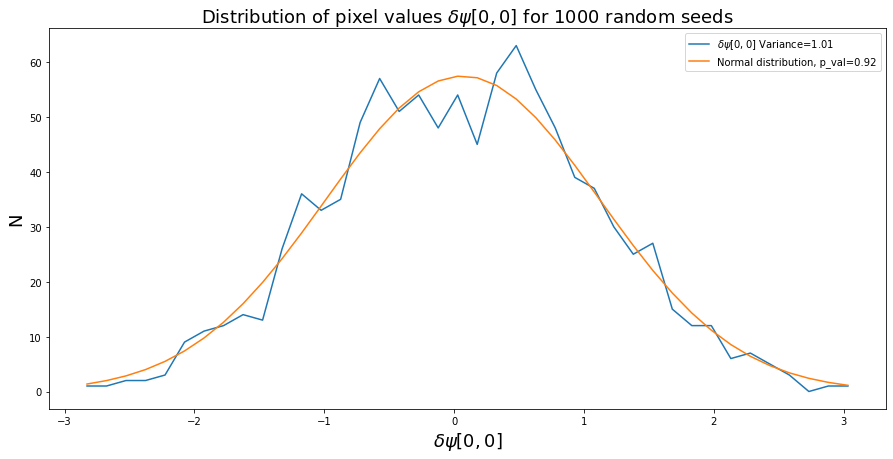

In [24]:
data,x=np.histogram(GRF_value,bins=40)
popt=fit_likelihood(x[1:],data,distr_func='normal',Poisson_errs=False)
norm_distr=normal_distr(x[1:],*popt)

plt.figure(figsize=(15,7))
plt.plot(x[1:],data,label=r'$\delta \psi[0,0]$'+' Variance={:.2f}'.format(GRF_value.var()))
plt.plot(x[1:],norm_distr,label='Normal distribution, p_val={:.2f}'.format(scipy.stats.ks_2samp(data,norm_distr)[1]))

plt.title('Distribution of pixel values '+r'$\delta \psi[0,0]$'+' for 1000 random seeds',fontsize=FS)
plt.xlabel(r'$\delta \psi[0,0]$',fontsize=FS)
plt.ylabel('N',fontsize=FS)
plt.legend()

In [26]:
sc.stats.ttest_1samp(GRF_value,0,alternative='two-sided')[1]

0.8869739148649979